In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import random
import cmath
import math

# Define our buildDataSet function here!

In [2]:
def buildDataSet(max_amplitude, min_sparsity, max_sparsity, vector_size, data_set_size):
    sparse_data = np.zeros((vector_size, data_set_size), dtype=float)  # Ensure float type
    
    # Iterate over the columns of the sparse_data matrix to define the data samples
    for i in range(data_set_size):
        sparsity = random.randint(min_sparsity, max_sparsity)
        indices = random.sample(range(vector_size), sparsity)
        amps = np.random.uniform(-max_amplitude, max_amplitude, sparsity)  # Use negative and positive values
        sparse_data[indices, i] = amps
    
    # Define the DFT matrix and multiply our sparse_data vectors with it to find dense data
    DFT = sp.linalg.dft(vector_size) / np.sqrt(vector_size)
    dense_data = DFT @ sparse_data
    
    return dense_data, sparse_data




## Build the dataset

In [3]:
max_amplitude = 100
min_sparsity = 3
max_sparsity = 5
vector_size = 100
data_set_size = 10000
dense_data, sparse_data = buildDataSet(max_amplitude,min_sparsity,max_sparsity,vector_size,data_set_size)



## Test the dataset

In [4]:
DFT = sp.linalg.dft(vector_size)/np.sqrt(vector_size)
iDFT = DFT.conj().T

# Check if the iDFT of the dense data is in fact sparse
print(iDFT@dense_data)


[[-1.12329870e-14-4.43811140e-14j  5.02938035e-15+1.32586678e-14j
  -1.37976102e-13+4.20882671e-14j ...  1.59224116e-13-2.47123973e-13j
  -3.80738776e-14-2.38198954e-14j  4.39603832e-14+1.43472166e-13j]
 [-2.55088411e-14+1.85730830e-14j  7.16767228e-14+6.18905141e-14j
  -1.59435990e-13-2.02334280e-13j ... -5.41714429e-14+3.02529303e-13j
  -2.47742989e-14+5.59335329e-14j  1.04983773e-13-2.43038195e-14j]
 [ 1.02529939e-14+2.88639279e-14j  6.54839015e-14-7.61333409e-14j
  -2.57115317e-13+2.57606792e-13j ...  4.80632137e-14-7.24136298e-14j
  -7.62730679e+01+9.10126875e-14j  8.51133545e-14-1.17827897e-13j]
 ...
 [-4.02183837e-14+1.65323534e-14j -9.00090983e-14+2.14957489e-14j
  -2.08633956e-14+7.51768876e-16j ...  2.11326972e-13+3.96545778e-14j
  -6.44316797e-14+1.50785797e-13j -1.69041966e-14+8.67479879e-14j]
 [ 4.95640004e-14+1.18679874e-13j  5.12411802e-14+4.20216947e-14j
   3.35454762e-14+5.11792995e-14j ... -7.06716964e-14-3.15469577e-13j
   1.06581410e-13+1.92577476e-15j  8.65440623e-

From the above results, we can see that our vectors are very sparse if we take the IDFT

## Setting up the dataset for Pytorch

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.init as init

from sklearn.model_selection import train_test_split

print(dense_data.shape)

X = np.concatenate((dense_data.real,dense_data.imag)).T
Y = np.concatenate((dense_data.real,dense_data.imag)).T

X_tensor = torch.tensor(X,dtype=torch.float)
Y_tensor = torch.tensor(Y,dtype=torch.float)
dataset = TensorDataset(X_tensor,Y_tensor)

dataloader = DataLoader(dataset,batch_size = 500,shuffle = True, )
print(X_tensor.shape)

(100, 10000)
torch.Size([10000, 200])


## Setting up the neural network

In [6]:
# class ExponentialComplexLinear(nn.Module):
#     def __init__(self, in_features, out_features):
#         super(ExponentialComplexLinear, self).__init__()
#
#         # Trainable phase angles (real-valued), this is where we are training the q-values) in the context of the exercise
#         self.phases = nn.Parameter(torch.randn(out_features, in_features) * 0.1)  # Small random initialization
#
#     def forward(self, x):
#         # Compute our matrix
#         W = torch.exp(1j * self.phases)  # Enforces |W| = 1
#
#         # Complex matrix multiplication)
#         return torch.matmul(x, W.t())

# class ComplexDecoder(nn.Module):
#     def __init__(self, encoding_dim, output_dim):
#         super(ComplexDecoder, self).__init__()
#
#         self.layers = nn.Sequential(
#             nn.Linear(200,400),
#             nn.ReLU(),
#             nn.Linear(400,400),
#             nn.ReLU(),
#             nn.Linear(400,200),
#             nn.Sigmoid()
#         )
#
#     def forward(self, x):
#         return self.layers(x)
def complex_xavier_init(tensor_real, tensor_imag, gain=1.0):
    # Apply Xavier initialization (using uniform variant) to both real and imaginary parts
    init.xavier_uniform_(tensor_real, gain=gain)
    init.xavier_uniform_(tensor_imag, gain=gain)

class ComplexLinearUnitary(nn.Module):
    # This class serves as the encoder layer. We are restricted to values which are of the form e^jq where q are trainable parameters
    # Notice that the input and output dimensions are half of what the actual vector size is! Because it is a complex value, our dimensions are twice as long
    def __init__(self,input_dim,output_dim):
        super(ComplexLinearUnitary,self).__init__()
        # Here we create the q-values of our unitary matrix. These are the parameters we are training such that each entry of our complex matrix to encode our data is |F_ij| = 1
        self.q_values = nn.Parameter(torch.randn(output_dim,input_dim))

    def forward(self,x):   
        # Compute unitary weights dynamically in each forward pass
        W_real = torch.cos(self.q_values)
        W_imag = torch.sin(self.q_values)
        W_top = torch.cat([W_real, -W_imag], dim=1)  # [W_real, -W_imag]
        W_bottom = torch.cat([W_imag, W_real], dim=1)  # [W_imag, W_real]
        W_total = torch.cat([W_top, W_bottom], dim=0)  # Stack rows to form the full matrix 
        out = torch.matmul(x,W_total.T)
        return out
    
class ComplexLinear(nn.Module):
    # Notice that the input and output dimensions are half of what the actual vector size is! Because it is a complex value, our dimensions are twice as long. This gets fixed because we make the matrix
    # W_total which multiplies [x_real;x_imag] and returns [y_real;y_imag]
    def __init__(self,input_dim,output_dim):
        super(ComplexLinear,self).__init__()
        # Here we create the complex matrix W
        #self.W_real = nn.Parameter(torch.randn(output_dim,input_dim))# eye(input_dim))
        #self.W_imag = nn.Parameter(torch.randn(output_dim,input_dim)) #zeros((input_dim,output_dim)))

        self.W_real = nn.Parameter(torch.empty(output_dim, input_dim))
        self.W_imag = nn.Parameter(torch.empty(output_dim, input_dim))
        self.reset_parameters()
    
    def reset_parameters(self):
        # Initialize both the real and imaginary parts using Xavier initialization.
        complex_xavier_init(self.W_real, self.W_imag)
        
    def forward(self,x):   
        # Compute unitary weights dynamically in each forward pass
        W_real = self.W_real
        W_imag = self.W_imag
        W_top = torch.cat([W_real, -W_imag], dim=1)  # [W_real, -W_imag]
        W_bottom = torch.cat([W_imag, W_real], dim=1)  # [W_imag, W_real]
        W_total = torch.cat([W_top, W_bottom], dim=0)  # Stack rows to form the full matrix 
        out = torch.matmul(x,W_total.T)
        return out

class FeedthroughEncoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(FeedthroughEncoder, self).__init__()
        """ compression_factor = input_dim / encoding_dim
        layer_size_factor = int(encoding_dim * compression_factor / 4) """

        self.encoder = ComplexLinear(input_dim,encoding_dim)

        self.decoder = nn.Sequential(
            ComplexLinear(encoding_dim,input_dim)
        )

    def forward(self, x):
        encoder_out = self.encoder(x)
        return self.decoder(encoder_out)


class LearnedAutoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim,hidden_dims):
        super(LearnedAutoencoder, self).__init__()

        self.encoder = ComplexLinearUnitary(input_dim,encoding_dim)
        layers = []
        prev_dim = encoding_dim*2
        for dim in hidden_dims:
            layers.append(nn.Linear(prev_dim,dim*2))
            layers.append(nn.ReLU())
            prev_dim = dim*2
        self.decoder = nn.Sequential(
            *layers,
            nn.Linear(prev_dim,input_dim*2)
        )

    def forward(self, x):
        encoder_out = self.encoder(x)

        return self.decoder(encoder_out)
    
class LearnedAutoencoderWithNoise(nn.Module):
    def __init__(self, input_dim, encoding_dim,hidden_dims,variance):
        super(LearnedAutoencoderWithNoise, self).__init__()
        self.variance = variance
        self.encoder = ComplexLinearUnitary(input_dim,encoding_dim)
        self.encoding_dim = encoding_dim
        self.variance
        layers = []
        prev_dim = encoding_dim*2
        for dim in hidden_dims:
            layers.append(nn.Linear(prev_dim,dim*2))
            layers.append(nn.ReLU())
            prev_dim = dim*2
        self.decoder = nn.Sequential(
            *layers,
            nn.Linear(prev_dim,input_dim*2)
        )

    def forward(self,x):
        encoder_out = self.encoder(x)
        noise_np = np.random.normal(0,self.variance,size=self.encoding_dim*2)
        noise = torch.tensor(noise_np,dtype=torch.float)
        noisy_y = encoder_out + noise
        return self.decoder(noisy_y)


class LearnedAutoencoderWithIQInbalance(nn.Module):
    def __init__(self, input_dim, encoding_dim,hidden_dims,b, d):
        super(LearnedAutoencoderWithIQInbalance, self).__init__()
        self.encoder = ComplexLinearUnitary(input_dim,encoding_dim)
        self.encoding_dim = encoding_dim
        self.r = 0.5*(1+b*np.exp(1j*d))
        layers = []
        prev_dim = encoding_dim*2
        for dim in hidden_dims:
            layers.append(nn.Linear(prev_dim,dim*2))
            layers.append(nn.ReLU())
            prev_dim = dim*2
        self.decoder = nn.Sequential(
            *layers,
            nn.Linear(prev_dim,input_dim*2)
        )

    def forward(self,x):
        encoder_out = self.encoder(x)
        y_real = encoder_out[:, :encoding_dim]
        y_imag = encoder_out[:, encoding_dim:]
        y = torch.complex(y_real,y_imag)
        yiq = self.r * y + (1-self.r.conjugate()) * (y_real - 1j*y_imag)
        yiqr = yiq.real
        yiqi = yiq.imag
        yiqstack = torch.cat((yiqr,yiqi),dim=1)
        return self.decoder(yiqstack)

""" class LearnedAutoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim,hidden_dims):
        super(LearnedAutoencoder, self).__init__()
        # compression_factor = input_dim / encoding_dim
        # layer_size_factor = int(encoding_dim * compression_factor / 4)

        self.encoder = ComplexLinear(input_dim,encoding_dim)
        layers = []
        prev_dim = encoding_dim
        for dim in hidden_dims:
            layers.append(ComplexLinear(prev_dim,dim))
            layers.append(nn.ReLU())
            prev_dim = dim
        self.decoder = nn.Sequential(
            *layers,
            ComplexLinear(prev_dim,input_dim)
        )

    def forward(self, x):
        encoder_out = self.encoder(x)
        return self.decoder(encoder_out) """

# class LearnedAutoencoder(nn.Module):
#     def __init__(self, input_dim, encoding_dim):
#         super(LearnedAutoencoder, self).__init__()
#         compression_factor = input_dim / encoding_dim
#         layer_size_factor = int(encoding_dim * compression_factor / 4)
#
#         self.encoder = nn.Sequential(
#             nn.Linear(input_dim, 15),
#             nn.ReLU(),
#             nn.Linear(17, 15),
#             nn.ReLU(),
#             nn.Linear(15, 12),
#             nn.ReLU(),
#             nn.Linear(12, 10),
#         )
#         self.decoder = nn.Sequential(
#             nn.Linear(10, 12),
#             nn.ReLU(),
#             nn.Linear(12, 15),
#             nn.ReLU(),
#             nn.Linear(15, 17),
#             nn.ReLU(),
#             nn.Linear(17, input_dim),
#             nn.ReLU()
#         )
#
#     def forward(self, x):
#         encoder_out = self.encoder(x)
#         return self.decoder(encoder_out)


' class LearnedAutoencoder(nn.Module):\n    def __init__(self, input_dim, encoding_dim,hidden_dims):\n        super(LearnedAutoencoder, self).__init__()\n        # compression_factor = input_dim / encoding_dim\n        # layer_size_factor = int(encoding_dim * compression_factor / 4)\n\n        self.encoder = ComplexLinear(input_dim,encoding_dim)\n        layers = []\n        prev_dim = encoding_dim\n        for dim in hidden_dims:\n            layers.append(ComplexLinear(prev_dim,dim))\n            layers.append(nn.ReLU())\n            prev_dim = dim\n        self.decoder = nn.Sequential(\n            *layers,\n            ComplexLinear(prev_dim,input_dim)\n        )\n\n    def forward(self, x):\n        encoder_out = self.encoder(x)\n        return self.decoder(encoder_out) '

## Training the feedthrough model

Epoch 1, Loss: 23.415335
Epoch 2, Loss: 5.518592
Epoch 3, Loss: 1.123136
Epoch 4, Loss: 0.126626
Epoch 5, Loss: 0.023552
Epoch 6, Loss: 0.003549
Epoch 7, Loss: 0.000561
Epoch 8, Loss: 0.000080
Epoch 9, Loss: 0.000014
Epoch 10, Loss: 0.000002
Epoch 11, Loss: 0.000000
Epoch 12, Loss: 0.000000
Epoch 13, Loss: 0.000000
Epoch 14, Loss: 0.000000
Epoch 15, Loss: 0.000000
Epoch 16, Loss: 0.000000
Epoch 17, Loss: 0.000000
Epoch 18, Loss: 0.000000
Epoch 19, Loss: 0.000000
Epoch 20, Loss: 0.000000


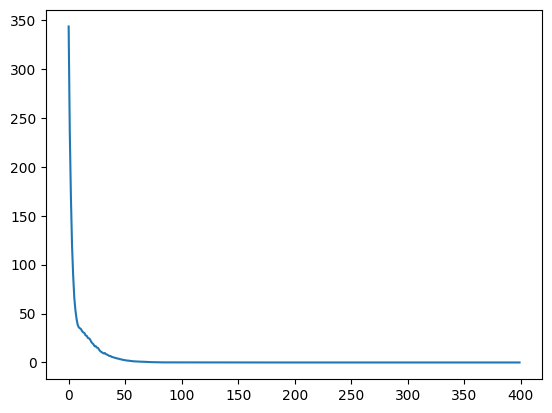

In [7]:
# Define the size of our "measurement" vector as encoding_dim. This needs to be larger than the sparsity of our matrix

# encoding_dim = max_sparsity
# encoding_dim = 100
# vector_size = 100
encoding_dim = vector_size
# Initialize model
feedthrough_model = FeedthroughEncoder(vector_size, encoding_dim)
optimizer = torch.optim.Adam(feedthrough_model.parameters(), lr=1E-2, weight_decay=1E-6)
loss_fn = nn.MSELoss()

# def complex_mse_loss(input, target):
#     return F.mse_loss(input, target)

# Training loop
losses = []
for epoch in range(20):
    for batch in dataloader:
        inputs, targets = batch  # Unpack the tuple
        optimizer.zero_grad()
        output = feedthrough_model(inputs)
        loss = loss_fn(output, targets)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    print(f"Epoch {epoch+1}, Loss: {loss.item():.6f}")

plt.plot(losses)
plt.show()

In [8]:
print(output[-1] - targets[-1])
print(output[0,:])

tensor([-1.4305e-06,  5.2452e-06, -1.1921e-06,  4.7684e-06,  9.5367e-07,
         2.1458e-06, -2.8610e-06,  2.8610e-06, -5.1409e-06,  6.9141e-06,
         6.8247e-06,  9.5367e-07, -1.9073e-06, -9.5367e-07, -9.5367e-06,
        -8.5831e-06,  2.3842e-06, -2.8610e-06, -3.3379e-06, -3.5763e-06,
        -2.8610e-06,  4.1723e-07,  4.7684e-06, -3.5763e-06, -2.3842e-06,
        -9.5367e-07,  7.3910e-06,  1.1921e-07,  3.0994e-06, -9.5367e-07,
        -9.5367e-07, -4.7684e-07, -2.1458e-06, -5.7220e-06, -3.8445e-06,
         2.9802e-06, -5.9828e-06,  7.6294e-06,  4.7684e-06,  8.1062e-06,
         6.6757e-06,  1.1444e-05,  4.7684e-06,  1.4305e-06,  8.1062e-06,
        -3.8147e-06, -5.2452e-06, -3.8147e-06, -8.5831e-06, -1.4305e-05,
         0.0000e+00, -8.5831e-06, -1.8120e-05, -9.5367e-07, -2.3842e-06,
        -1.4305e-06,  1.1444e-05,  7.1526e-06,  4.2915e-06,  1.9073e-06,
         7.6294e-06,  6.6757e-06,  3.8147e-06,  9.5367e-07,  1.8589e-06,
         1.9670e-06,  2.3246e-06, -7.6294e-06, -2.8

## Train the AutoEncoder Model

100
Epoch 1, Loss: 64.599457
Epoch 2, Loss: 62.241676
Epoch 3, Loss: 59.890820
Epoch 4, Loss: 52.354435
Epoch 5, Loss: 45.448074
Epoch 6, Loss: 39.794868
Epoch 7, Loss: 35.408218
Epoch 8, Loss: 33.126007
Epoch 9, Loss: 30.280630
Epoch 10, Loss: 28.642515
Epoch 11, Loss: 25.450476
Epoch 12, Loss: 24.061272
Epoch 13, Loss: 24.001869
Epoch 14, Loss: 21.932312
Epoch 15, Loss: 21.134212
Epoch 16, Loss: 21.320185
Epoch 17, Loss: 19.402077
Epoch 18, Loss: 19.053741
Epoch 19, Loss: 17.357809
Epoch 20, Loss: 18.220091
Epoch 21, Loss: 17.224504
Epoch 22, Loss: 16.722794
Epoch 23, Loss: 15.731210
Epoch 24, Loss: 16.442186
Epoch 25, Loss: 15.601315
Epoch 26, Loss: 14.420560
Epoch 27, Loss: 14.634054
Epoch 28, Loss: 14.085540
Epoch 29, Loss: 13.956408
Epoch 30, Loss: 13.573402
Epoch 31, Loss: 12.432314
Epoch 32, Loss: 12.329725
Epoch 33, Loss: 12.328003
Epoch 34, Loss: 12.724202
Epoch 35, Loss: 12.311552
Epoch 36, Loss: 11.934821
Epoch 37, Loss: 12.013778
Epoch 38, Loss: 11.544378
Epoch 39, Loss: 1

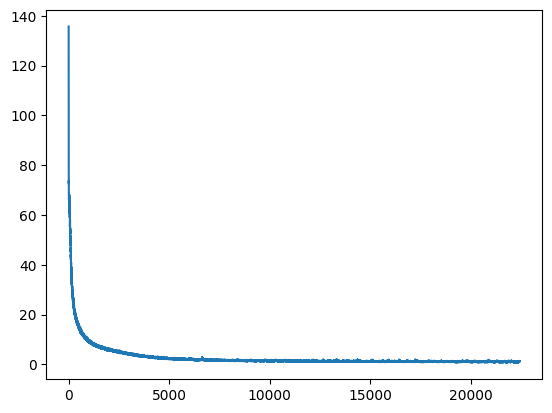

In [9]:
# Training variables: Beta_momentum, beta_variance, learning_rate, encoding_dim, sparsity, weight_decay

# Current Iteration: 1
# Beta_momentum: 0.95
# Beta_variance: 0.99
# Learning_rate: 1E-3
# weight_decay = 0
# sparsity = 3-5

encoding_dim = 50
print(vector_size)

# Initialize model
hidden_dims = np.array([60,80])
learned_autoencoder_model = LearnedAutoencoder(vector_size,encoding_dim,hidden_dims)
optimizer = torch.optim.Adam(learned_autoencoder_model.parameters(), lr=1E-3, betas=(0.9,0.999))
loss_fn = nn.MSELoss()

# def complex_mse_loss(input, target):
#     return F.mse_loss(input, target)

# Training loop
losses = []
lowest_loss = float("inf")
for epoch in range(5000):
    for batch in dataloader:
        inputs, targets = batch  # Unpack the tuple
        optimizer.zero_grad()
        output = learned_autoencoder_model(inputs)
        loss = loss_fn(output, targets)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    if loss < lowest_loss:
        lowest_loss = loss
        early_stopping_counter = 0
        best_model = learned_autoencoder_model
    else:
        early_stopping_counter += 1
        if early_stopping_counter > 100:
            learned_autoencoder_model = best_model
            print(f"stopped early after {epoch+1} epochs")
            break

    print(f"Epoch {epoch+1}, Loss: {loss.item():.6f}")

plt.plot(losses)
plt.show()

Some conclusions that we have found so far:
- Batch size must be minimally greater than 100. 500 seems to work well.
- 2 hidden layers of size 50,70 leads to a loss of 0.3 MSE
- Decreasing variance below 0.999 does not seem to have a positive effect


## Train noisy model

In [10]:
# Training variables: Beta_momentum, beta_variance, learning_rate, encoding_dim, sparsity, weight_decay

# Current Iteration: 1
# Beta_momentum: 0.9
# Beta_variance: 0.999
# Learning_rate: 1E-3
# weight_decay = 0
# sparsity = 3-5
# variance = 1
noisy_models = []
noisy_losses = []
SNR = [0.1, 0.2, 0.3, 0.4, 0.5]
for ratio in SNR:
    encoding_dim = 50
    variance = 10
    # Initialize model
    hidden_dims = np.array([60,80])
    noisy_autoencoder_model = LearnedAutoencoderWithNoise(vector_size,encoding_dim,hidden_dims,variance)
    optimizer = torch.optim.Adam(noisy_autoencoder_model.parameters(), lr=1E-3, betas=(0.9,0.999))
    loss_fn = nn.MSELoss()
# def complex_mse_loss(input, target):
#     return F.mse_loss(input, target)
    # Training loop
    losses = []
    lowest_loss = float("inf")
    for epoch in range(10000):
        for batch in dataloader:
            inputs, targets = batch  # Unpack the tuple
            optimizer.zero_grad()
            output = noisy_autoencoder_model(inputs)
            loss = loss_fn(output, targets)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        if loss< lowest_loss:
            lowest_loss = loss
            early_stopping_counter = 0
            best_model = noisy_autoencoder_model
        else:
            early_stopping_counter += 1
            if early_stopping_counter > 100:
                noisy_autoencoder_model = best_model
                print(f"stopped early after {epoch+1} epochs, with loss {lowest_loss:.6f}")
                break

        print(f"Epoch {epoch+1}, Loss: {loss.item():.6f}")
    noisy_models.append(best_model)
    noisy_losses.append(lowest_loss)
# plt.plot(losses)
# plt.show()



Epoch 1, Loss: 63.666016
Epoch 2, Loss: 63.286030
Epoch 3, Loss: 59.190826
Epoch 4, Loss: 54.098831
Epoch 5, Loss: 48.542946
Epoch 6, Loss: 43.170891
Epoch 7, Loss: 41.134621
Epoch 8, Loss: 37.802143
Epoch 9, Loss: 34.931179
Epoch 10, Loss: 32.099976
Epoch 11, Loss: 33.389534
Epoch 12, Loss: 29.706644
Epoch 13, Loss: 29.612663
Epoch 14, Loss: 29.278666
Epoch 15, Loss: 27.282982
Epoch 16, Loss: 26.769915
Epoch 17, Loss: 27.188971
Epoch 18, Loss: 25.434080
Epoch 19, Loss: 26.211475
Epoch 20, Loss: 23.985100
Epoch 21, Loss: 23.930492
Epoch 22, Loss: 23.386274
Epoch 23, Loss: 23.153166
Epoch 24, Loss: 22.747187
Epoch 25, Loss: 22.736389
Epoch 26, Loss: 20.956129
Epoch 27, Loss: 20.695370
Epoch 28, Loss: 21.130400
Epoch 29, Loss: 19.786867
Epoch 30, Loss: 21.746807
Epoch 31, Loss: 19.422321
Epoch 32, Loss: 19.649454
Epoch 33, Loss: 19.159643
Epoch 34, Loss: 19.548897
Epoch 35, Loss: 18.386312
Epoch 36, Loss: 20.150885
Epoch 37, Loss: 18.234213
Epoch 38, Loss: 18.443478
Epoch 39, Loss: 17.77

## Initialize pre-trained noiseless model

In [11]:
# Instantiate your model architecture first
encoding_dim = 50
vector_size = 100
hidden_dims = np.array([50,70])
pretrained_model = LearnedAutoencoder(vector_size,encoding_dim,hidden_dims)
# Load the state dictionary
pretrained_model.load_state_dict(torch.load("model_state_hidden_layers_50_70.pt"))

pretrained_model.eval()  # Set the model to evaluation mode if needed

LearnedAutoencoder(
  (encoder): ComplexLinearUnitary()
  (decoder): Sequential(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=140, bias=True)
    (3): ReLU()
    (4): Linear(in_features=140, out_features=200, bias=True)
  )
)

## Show the output for a given sparse input vector



In [12]:
# Here we generate a test vector from our buildDataSet function, put it through the model and look at the output

h, x = buildDataSet(max_amplitude,min_sparsity,max_sparsity,vector_size,1)

H = np.concatenate((h.real,h.imag)).T

H_tensor = torch.tensor(H,dtype=torch.float)

H_hat = pretrained_model(H_tensor)

h_hat = np.array(H_hat.detach())

h_real,h_imag = np.split(h_hat,2,1)
h_hat = h_real + 1j*h_imag
h_hat = h_hat.reshape(-1,1)
DFT = sp.linalg.dft(vector_size)/np.sqrt(vector_size)
iDFT = DFT.conj().T


x_hat = iDFT@h_hat
indices = range(len(x_hat))


/tmp/ipykernel_3959/2394845549.py:11: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  h_hat = np.array(H_hat.detach())


/home/daan/PycharmProjects/Compression/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/daan/PycharmProjects/Compression/.venv/lib/python3.12/site-packages/numpy/ma/core.py:3463: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval


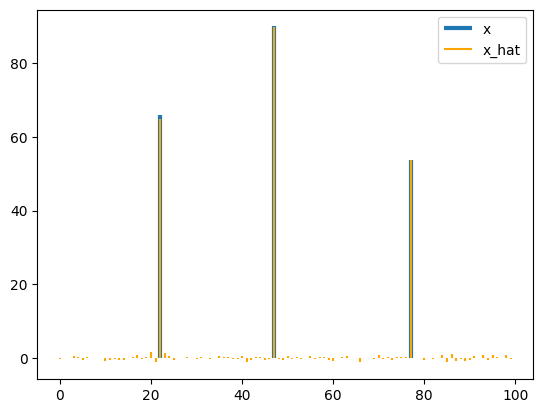

In [13]:
plt.vlines(indices,0,x,linewidth=3)
plt.vlines(indices,0,x_hat,colors="orange")

plt.legend(("x","x_hat"))

## Extract the encoding matrix, generate a (noisy) y and use the decoder to find $\hat{h}$, then plot $\hat{x}$

In [14]:
# Load the autoencoder

encoding_dim = 50
vector_size = 100
hidden_dims = np.array([60,80])
variance = 10
noisy_autoencoder = LearnedAutoencoderWithNoise(vector_size,encoding_dim,hidden_dims,variance)
noisy_autoencoder.load_state_dict(torch.load("noisy_autoencoder_10var_60_80.pt",))
noisy_autoencoder.eval()

# Build the W matrix
q_values = noisy_autoencoder_model.encoder.q_values

W_real = torch.cos(q_values)
W_imag = torch.sin(q_values)
W_top = torch.cat([W_real, -W_imag], dim=1)  # [W_real, -W_imag]
W_bottom = torch.cat([W_imag, W_real], dim=1)  # [W_imag, W_real]
W_total = torch.cat([W_top, W_bottom], dim=0)  # Stack rows to form the full matrix 

# Build the input vector

h, x = buildDataSet(max_amplitude,min_sparsity,max_sparsity,vector_size,1)

H = np.concatenate((h.real,h.imag)).T

H_tensor = torch.tensor(H,dtype=torch.float)

y = torch.matmul(H_tensor,W_total.T)

# Make the noise

variance = 10

noise_np = np.random.normal(0,variance,size=100)
noise = torch.tensor(noise_np,dtype=torch.float)
noisy_y = y + noise

# Rebuild h, and x from the noisy y using the decoder

H_hat = noisy_autoencoder_model.decoder(noisy_y)

h_hat = np.array(H_hat.detach())

h_real,h_imag = np.split(h_hat,2,1)
h_hat = h_real + 1j*h_imag
h_hat = h_hat.reshape(-1,1)
DFT = sp.linalg.dft(vector_size)/np.sqrt(vector_size)
iDFT = DFT.conj().T


x_hat = iDFT@h_hat
indices = range(len(x_hat))

/tmp/ipykernel_3959/3878500147.py:42: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  h_hat = np.array(H_hat.detach())


## Plotting

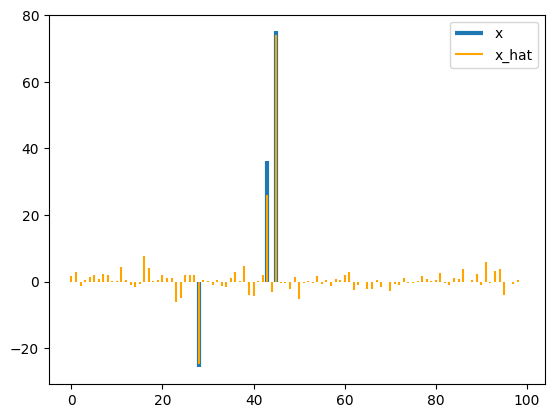

In [15]:
plt.vlines(indices,0,x,linewidth=3)
plt.vlines(indices,0,x_hat,colors="orange")

plt.legend(("x","x_hat"))

## Show the weights

In [16]:
# THIS DOESN'T WORK. TO BE FIXED

for idx, layer in enumerate(pretrained_model.decoder):
    # Check if the layer is an instance of ComplexLinear
    if isinstance(layer, nn.Linear):
        print(f"Decoder layer {idx} (ComplexLinear) W_real:")
        print(layer.weight)
        print(f"Decoder layer {idx} (ComplexLinear) W_imag:")
        print(layer.weight)

Decoder layer 0 (ComplexLinear) W_real:
Parameter containing:
tensor([[-0.0016, -0.0323,  0.1041,  ...,  0.0468, -0.0592,  0.0327],
        [-0.0235, -0.0134, -0.0171,  ...,  0.0216,  0.0314,  0.0259],
        [ 0.0065, -0.0328, -0.0397,  ..., -0.0214,  0.0142,  0.0223],
        ...,
        [ 0.0561, -0.1109,  0.1659,  ..., -0.0796, -0.3391,  0.1045],
        [-0.0328, -0.0145,  0.0484,  ..., -0.0230,  0.0081,  0.0506],
        [ 0.0097, -0.0984,  0.0116,  ...,  0.1054,  0.0210,  0.0204]],
       requires_grad=True)
Decoder layer 0 (ComplexLinear) W_imag:
Parameter containing:
tensor([[-0.0016, -0.0323,  0.1041,  ...,  0.0468, -0.0592,  0.0327],
        [-0.0235, -0.0134, -0.0171,  ...,  0.0216,  0.0314,  0.0259],
        [ 0.0065, -0.0328, -0.0397,  ..., -0.0214,  0.0142,  0.0223],
        ...,
        [ 0.0561, -0.1109,  0.1659,  ..., -0.0796, -0.3391,  0.1045],
        [-0.0328, -0.0145,  0.0484,  ..., -0.0230,  0.0081,  0.0506],
        [ 0.0097, -0.0984,  0.0116,  ...,  0.1054,  

In [17]:
inbalanced_models = []
inbalanced_losses = []
inbalance_levels = [0.2, 0.4, 0.6, 0.8, 1]
for level in inbalance_levels:
    encoding_dim = 50
    b = 1 - (0.2 * level)
    d = level * np.pi/8
    # Initialize model
    hidden_dims = np.array([60,80])
    inbalanced_autoencoder_model = LearnedAutoencoderWithIQInbalance(vector_size,encoding_dim,hidden_dims,b,d)
    optimizer = torch.optim.Adam(inbalanced_autoencoder_model.parameters(), lr=1E-3, betas=(0.9,0.999))
    loss_fn = nn.MSELoss()

    # def complex_mse_loss(input, target):
    #     return F.mse_loss(input, target)

    # Training loop
    losses = []
    lowest_loss = float("inf")
    for epoch in range(10000):
        for batch in dataloader:
            inputs, targets = batch  # Unpack the tuple
            optimizer.zero_grad()
            output = inbalanced_autoencoder_model(inputs)
            loss = loss_fn(output, targets)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        if loss< lowest_loss:
            lowest_loss = loss
            early_stopping_counter = 0
            best_model = inbalanced_autoencoder_model
        else:
            early_stopping_counter += 1
            if early_stopping_counter > 100:
                inbalanced_autoencoder_model = best_model
                print(f"stopped early after {epoch+1} epochs, with loss of {lowest_loss:.6f}")
                break

        print(f"Epoch {epoch+1}, Loss: {loss.item():.6f}")
    inbalanced_models.append(best_model)
    inbalanced_losses.append(lowest_loss)
# plt.plot(losses)
# plt.show()


Epoch 1, Loss: 63.676708
Epoch 2, Loss: 64.865921
Epoch 3, Loss: 56.737125
Epoch 4, Loss: 49.938950
Epoch 5, Loss: 45.593170
Epoch 6, Loss: 38.569221
Epoch 7, Loss: 33.534916
Epoch 8, Loss: 31.765310
Epoch 9, Loss: 28.859116
Epoch 10, Loss: 28.601397
Epoch 11, Loss: 26.321871
Epoch 12, Loss: 25.454430
Epoch 13, Loss: 22.915094
Epoch 14, Loss: 22.176895
Epoch 15, Loss: 22.344761
Epoch 16, Loss: 20.087753
Epoch 17, Loss: 20.081442
Epoch 18, Loss: 19.092197
Epoch 19, Loss: 17.929054
Epoch 20, Loss: 18.401760
Epoch 21, Loss: 17.143723
Epoch 22, Loss: 16.682241
Epoch 23, Loss: 16.501905
Epoch 24, Loss: 15.642592
Epoch 25, Loss: 15.965652
Epoch 26, Loss: 15.090996
Epoch 27, Loss: 14.554711
Epoch 28, Loss: 13.546480
Epoch 29, Loss: 13.728550
Epoch 30, Loss: 13.356494
Epoch 31, Loss: 13.216888
Epoch 32, Loss: 12.865441
Epoch 33, Loss: 12.318183
Epoch 34, Loss: 12.336677
Epoch 35, Loss: 12.188704
Epoch 36, Loss: 12.101129
Epoch 37, Loss: 11.405965
Epoch 38, Loss: 10.769258
Epoch 39, Loss: 12.06

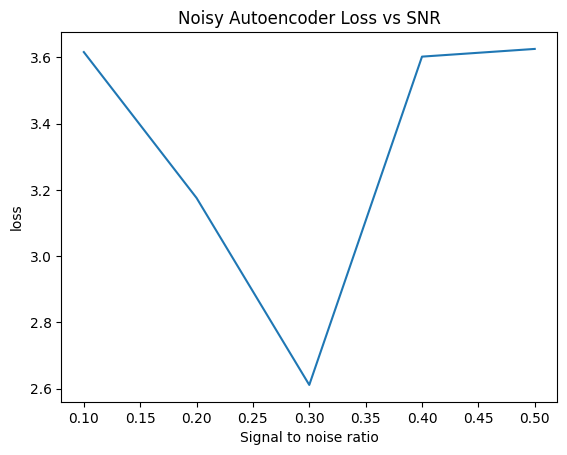

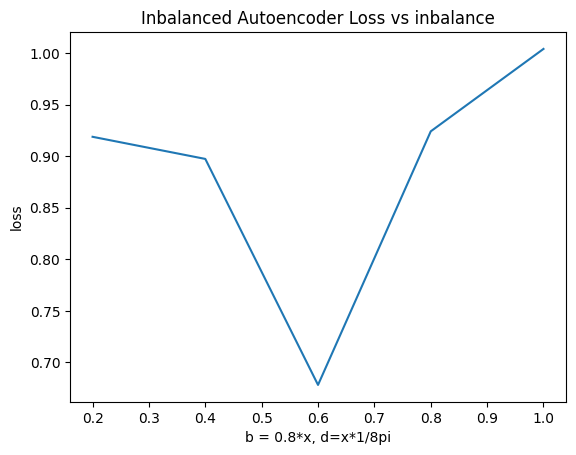

In [25]:
plt.rcParams['text.usetex'] = False

plt.plot(SNR, noisy_losses)
plt.title("Noisy Autoencoder Loss vs SNR")
plt.xlabel("Signal to noise ratio")
plt.ylabel("loss")
plt.show()


plt.figure()
plt.plot(inbalance_levels, inbalanced_losses)
plt.title("Inbalanced Autoencoder Loss vs inbalance")
plt.xlabel("b = 0.8*x, d=x*1/8pi")
plt.ylabel("loss")
plt.show()